# 1. Build an image segmentation model using pytorch

In [1]:
import torch
import torch.nn as nn
from torch import optim
import torchvision.transforms.functional as TF

import os 
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import cv2
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
class TripleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TripleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),# to make the output matrix the same height and weight
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

class TripleUNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64,128,256,512],
    ):
        super(TripleUNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 161*161, output 160* 160
        #Down part of TripleUNET
        for feature in features:
            self.downs.append(TripleConv(in_channels, feature))
            in_channels = feature

        #Up part of TripleUNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2, 
                )#double the height and weight
            )
            self.ups.append(TripleConv(feature*2, feature))
            
        self.bottleneck = TripleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size = 1)
        
        
    def forward(self, x):
        skip_connections = []
        
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
            
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]
            
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
            
        return self.final_conv(x)

In [6]:
x = torch.randn((3,1,160,160))
model = TripleUNET(in_channels=1, out_channels=1)
preds = model(x)
print(preds.shape)
print(x.shape)
assert preds.shape == x.shape

torch.Size([3, 1, 160, 160])
torch.Size([3, 1, 160, 160])


In [3]:
class LungDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = os.listdir(image_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        if self.image_transform is not None:
            image = self.image_transform(image)
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)

        mask = np.array(mask, dtype=np.float32)
        mask[mask == 255.0] = 1.0
        
        return image, mask

In [4]:
learning_rate = 0.001
device = 'cuda'
batch_size = 4
epochs = 50
image_height = 160
image_width = 160
train_img_dir = './Lung_segmentation/Train/Images/'
train_mask_dir = './Lung_segmentation/Train/Masks/'
test_img_dir = './Lung_segmentation/Test/Images/'
test_mask_dir = './Lung_segmentation/Test/Masks/'

Image size (Height, Width, Channels): (1024, 1024, 3)


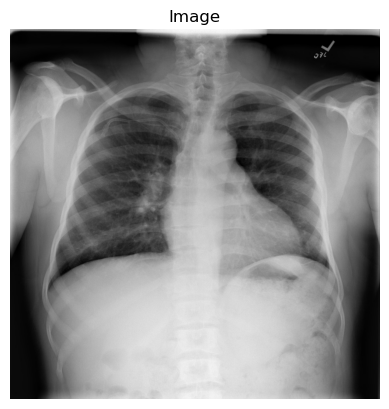

In [5]:
img = cv2.imread('./Lung_segmentation/Train/Images/1.png')

# Check the size of the image
print("Image size (Height, Width, Channels):", img.shape)

# Convert BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Plot the image
plt.imshow(img_rgb)
plt.title("Image")
plt.axis('off') # to turn off the axis numbers
plt.show()

In [6]:
def dice_coeff(pred, target):
    smooth = 1e-5
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice

def iou_coeff(pred, target):
    smooth = 1e-5
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

In [7]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def train_fn(loader, model, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    total_dice = 0
    total_iou = 0
    num_batches = len(loader)

    loop = tqdm(loader, leave=True)  
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device)
        targets = targets.to(device).long()
        targets = targets.squeeze(1)

        optimizer.zero_grad()
        predictions = model(data)
        loss = loss_fn(predictions, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        predictions = torch.argmax(predictions, dim=1)
        total_dice += dice_coeff(predictions, targets)
        total_iou += iou_coeff(predictions, targets)
        
        # total_dice += dice_coeff(torch.sigmoid(predictions), targets)
        # total_iou += iou_coeff(torch.sigmoid(predictions), targets)

        loop.set_postfix(loss=loss.item()) 

    avg_loss = total_loss / num_batches
    avg_dice = total_dice / num_batches
    avg_iou = total_iou / num_batches
    return avg_loss, avg_dice, avg_iou



train_image_transforms = transforms.Compose([
    transforms.Resize((image_height, image_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])
train_mask_transforms = transforms.Compose([
    transforms.Resize((image_height, image_width)),
    transforms.ToTensor(),
    transforms.Lambda(lambda y: (y == 1).float())
])
test_image_transforms = transforms.Compose(
    [
    transforms.Resize((image_height, image_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])
test_mask_transforms = transforms.Compose([
    transforms.Resize((image_height, image_width)),
    transforms.ToTensor(),
    transforms.Lambda(lambda y: (y == 1).float())
])


In [8]:
def get_loaders(
        train_img_dir, 
        train_mask_dir, 
        test_img_dir, 
        test_mask_dir, 
        batch_size, 
        train_image_transforms, 
        train_mask_transforms,
        test_image_transforms,
        test_mask_transforms
    ):
    train_ds = LungDataset(train_img_dir, train_mask_dir, image_transform=train_image_transforms, mask_transform=train_mask_transforms)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    
    test_ds = LungDataset(test_img_dir, test_mask_dir, image_transform=test_image_transforms, mask_transform=test_mask_transforms)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

In [9]:
model = TripleUNET(in_channels=3, out_channels=2).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    
train_loader, test_loader = get_loaders(
    train_img_dir,
    train_mask_dir, 
    test_img_dir, 
    test_mask_dir, 
    batch_size, 
    train_image_transforms, 
    train_mask_transforms,
    test_image_transforms,
    test_mask_transforms)

In [10]:
def evaluate_fn(loader, model, loss_fn, device):
    model.eval()
    total_loss = 0
    total_dice = 0
    total_iou = 0
    num_batches = len(loader)
    
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(loader):
            data = data.to(device)
            targets = targets.to(device).long()
            targets = targets.squeeze(1)
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            total_loss += loss.item()
            
            predictions = torch.argmax(predictions, dim=1)
            total_dice += dice_coeff(predictions, targets)
            total_iou += iou_coeff(predictions, targets)

    avg_loss = total_loss / num_batches
    avg_dice = total_dice / num_batches
    avg_iou = total_iou / num_batches
    return avg_loss, avg_dice, avg_iou

# 2. Train your model using [lung segmentation datasets](https://github.com/YoushanZhang/Lung_Segmentation)

In [15]:
train_losses, test_losses = [], []
train_dices, test_dices = [], []
train_ious, test_ious = [], []

for epoch in range(epochs):
    print(f"Epoch [{epoch+1}/{epochs}]")
    
    train_loss, train_dice, train_iou = train_fn(train_loader, model, optimizer, loss_fn, device)
    train_losses.append(train_loss)
    train_dices.append(train_dice)
    train_ious.append(train_iou)

    test_loss, test_dice, test_iou = evaluate_fn(test_loader, model, loss_fn, device)
    test_losses.append(test_loss)
    test_dices.append(test_dice)
    test_ious.append(test_iou)

    print(f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, Train IoU: {train_iou:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Dice: {test_dice:.4f}, Test IoU: {test_iou:.4f}")


Epoch [1/50]


100%|██████████| 200/200 [00:39<00:00,  5.03it/s, loss=0.171]


Train Loss: 0.2515, Train Dice: 0.8178, Train IoU: 0.7024
Test Loss: 0.2384, Test Dice: 0.8625, Test IoU: 0.7624
Epoch [2/50]


100%|██████████| 200/200 [00:39<00:00,  5.10it/s, loss=0.116] 


Train Loss: 0.1499, Train Dice: 0.8926, Train IoU: 0.8076
Test Loss: 0.1267, Test Dice: 0.9156, Test IoU: 0.8450
Epoch [3/50]


100%|██████████| 200/200 [00:39<00:00,  5.03it/s, loss=0.109] 


Train Loss: 0.1266, Train Dice: 0.9100, Train IoU: 0.8363
Test Loss: 0.1952, Test Dice: 0.8491, Test IoU: 0.7401
Epoch [4/50]


100%|██████████| 200/200 [00:38<00:00,  5.26it/s, loss=0.0758]


Train Loss: 0.1087, Train Dice: 0.9217, Train IoU: 0.8557
Test Loss: 0.0968, Test Dice: 0.9337, Test IoU: 0.8764
Epoch [5/50]


100%|██████████| 200/200 [00:37<00:00,  5.31it/s, loss=0.111] 


Train Loss: 0.0994, Train Dice: 0.9285, Train IoU: 0.8673
Test Loss: 0.1079, Test Dice: 0.9317, Test IoU: 0.8729
Epoch [6/50]


100%|██████████| 200/200 [00:38<00:00,  5.22it/s, loss=0.0885]


Train Loss: 0.0967, Train Dice: 0.9298, Train IoU: 0.8696
Test Loss: 0.0971, Test Dice: 0.9336, Test IoU: 0.8761
Epoch [7/50]


100%|██████████| 200/200 [00:38<00:00,  5.17it/s, loss=0.0572]


Train Loss: 0.0928, Train Dice: 0.9325, Train IoU: 0.8743
Test Loss: 0.0952, Test Dice: 0.9357, Test IoU: 0.8797
Epoch [8/50]


100%|██████████| 200/200 [00:38<00:00,  5.22it/s, loss=0.0848]


Train Loss: 0.0869, Train Dice: 0.9360, Train IoU: 0.8804
Test Loss: 0.0891, Test Dice: 0.9416, Test IoU: 0.8901
Epoch [9/50]


100%|██████████| 200/200 [00:38<00:00,  5.21it/s, loss=0.102] 


Train Loss: 0.0862, Train Dice: 0.9365, Train IoU: 0.8814
Test Loss: 0.0837, Test Dice: 0.9436, Test IoU: 0.8935
Epoch [10/50]


100%|██████████| 200/200 [00:38<00:00,  5.21it/s, loss=0.094] 


Train Loss: 0.0814, Train Dice: 0.9401, Train IoU: 0.8879
Test Loss: 0.0792, Test Dice: 0.9450, Test IoU: 0.8961
Epoch [11/50]


100%|██████████| 200/200 [00:38<00:00,  5.22it/s, loss=0.0795]


Train Loss: 0.0822, Train Dice: 0.9393, Train IoU: 0.8862
Test Loss: 0.0830, Test Dice: 0.9391, Test IoU: 0.8855
Epoch [12/50]


100%|██████████| 200/200 [00:38<00:00,  5.24it/s, loss=0.0567]


Train Loss: 0.0787, Train Dice: 0.9422, Train IoU: 0.8912
Test Loss: 0.0740, Test Dice: 0.9484, Test IoU: 0.9022
Epoch [13/50]


100%|██████████| 200/200 [00:38<00:00,  5.22it/s, loss=0.0857]


Train Loss: 0.0763, Train Dice: 0.9424, Train IoU: 0.8917
Test Loss: 0.0991, Test Dice: 0.9261, Test IoU: 0.8629
Epoch [14/50]


100%|██████████| 200/200 [00:38<00:00,  5.23it/s, loss=0.0811]


Train Loss: 0.0757, Train Dice: 0.9436, Train IoU: 0.8938
Test Loss: 0.0740, Test Dice: 0.9486, Test IoU: 0.9026
Epoch [15/50]


100%|██████████| 200/200 [00:38<00:00,  5.21it/s, loss=0.0593]


Train Loss: 0.0771, Train Dice: 0.9419, Train IoU: 0.8907
Test Loss: 0.0812, Test Dice: 0.9471, Test IoU: 0.9001
Epoch [16/50]


100%|██████████| 200/200 [00:38<00:00,  5.19it/s, loss=0.058] 


Train Loss: 0.0725, Train Dice: 0.9458, Train IoU: 0.8976
Test Loss: 0.0741, Test Dice: 0.9492, Test IoU: 0.9036
Epoch [17/50]


100%|██████████| 200/200 [00:38<00:00,  5.21it/s, loss=0.0707]


Train Loss: 0.0758, Train Dice: 0.9431, Train IoU: 0.8929
Test Loss: 0.1024, Test Dice: 0.9324, Test IoU: 0.8740
Epoch [18/50]


100%|██████████| 200/200 [00:38<00:00,  5.22it/s, loss=0.0751]


Train Loss: 0.0745, Train Dice: 0.9439, Train IoU: 0.8942
Test Loss: 0.0694, Test Dice: 0.9501, Test IoU: 0.9053
Epoch [19/50]


100%|██████████| 200/200 [00:38<00:00,  5.22it/s, loss=0.0713]


Train Loss: 0.0697, Train Dice: 0.9472, Train IoU: 0.9001
Test Loss: 0.0760, Test Dice: 0.9498, Test IoU: 0.9048
Epoch [20/50]


100%|██████████| 200/200 [00:38<00:00,  5.23it/s, loss=0.0727]


Train Loss: 0.0702, Train Dice: 0.9471, Train IoU: 0.9000
Test Loss: 0.0737, Test Dice: 0.9477, Test IoU: 0.9009
Epoch [21/50]


100%|██████████| 200/200 [00:38<00:00,  5.23it/s, loss=0.0774]


Train Loss: 0.0673, Train Dice: 0.9490, Train IoU: 0.9031
Test Loss: 0.0713, Test Dice: 0.9487, Test IoU: 0.9028
Epoch [22/50]


100%|██████████| 200/200 [00:38<00:00,  5.23it/s, loss=0.0627]


Train Loss: 0.0693, Train Dice: 0.9471, Train IoU: 0.9000
Test Loss: 0.0776, Test Dice: 0.9445, Test IoU: 0.8950
Epoch [23/50]


100%|██████████| 200/200 [00:38<00:00,  5.20it/s, loss=0.0593]


Train Loss: 0.0695, Train Dice: 0.9477, Train IoU: 0.9012
Test Loss: 0.0734, Test Dice: 0.9489, Test IoU: 0.9031
Epoch [24/50]


100%|██████████| 200/200 [00:38<00:00,  5.23it/s, loss=0.0752]


Train Loss: 0.0700, Train Dice: 0.9468, Train IoU: 0.8996
Test Loss: 0.0715, Test Dice: 0.9507, Test IoU: 0.9064
Epoch [25/50]


100%|██████████| 200/200 [00:38<00:00,  5.22it/s, loss=0.0609]


Train Loss: 0.0652, Train Dice: 0.9498, Train IoU: 0.9048
Test Loss: 0.0797, Test Dice: 0.9441, Test IoU: 0.8944
Epoch [26/50]


100%|██████████| 200/200 [00:38<00:00,  5.23it/s, loss=0.056] 


Train Loss: 0.0653, Train Dice: 0.9502, Train IoU: 0.9053
Test Loss: 0.0789, Test Dice: 0.9467, Test IoU: 0.8991
Epoch [27/50]


100%|██████████| 200/200 [00:38<00:00,  5.23it/s, loss=0.0578]


Train Loss: 0.0645, Train Dice: 0.9506, Train IoU: 0.9061
Test Loss: 0.0689, Test Dice: 0.9507, Test IoU: 0.9063
Epoch [28/50]


100%|██████████| 200/200 [00:38<00:00,  5.22it/s, loss=0.0496]


Train Loss: 0.0628, Train Dice: 0.9517, Train IoU: 0.9080
Test Loss: 0.0686, Test Dice: 0.9529, Test IoU: 0.9102
Epoch [29/50]


100%|██████████| 200/200 [00:38<00:00,  5.23it/s, loss=0.0746]


Train Loss: 0.0618, Train Dice: 0.9527, Train IoU: 0.9098
Test Loss: 0.0692, Test Dice: 0.9517, Test IoU: 0.9082
Epoch [30/50]


100%|██████████| 200/200 [00:38<00:00,  5.23it/s, loss=0.0818]


Train Loss: 0.0688, Train Dice: 0.9484, Train IoU: 0.9022
Test Loss: 0.0799, Test Dice: 0.9481, Test IoU: 0.9017
Epoch [31/50]


100%|██████████| 200/200 [00:38<00:00,  5.23it/s, loss=0.0754]


Train Loss: 0.0662, Train Dice: 0.9498, Train IoU: 0.9047
Test Loss: 0.0752, Test Dice: 0.9482, Test IoU: 0.9018
Epoch [32/50]


100%|██████████| 200/200 [00:38<00:00,  5.24it/s, loss=0.0537]


Train Loss: 0.0615, Train Dice: 0.9527, Train IoU: 0.9099
Test Loss: 0.0687, Test Dice: 0.9508, Test IoU: 0.9065
Epoch [33/50]


100%|██████████| 200/200 [00:38<00:00,  5.23it/s, loss=0.0638]


Train Loss: 0.0640, Train Dice: 0.9505, Train IoU: 0.9059
Test Loss: 0.0678, Test Dice: 0.9522, Test IoU: 0.9089
Epoch [34/50]


100%|██████████| 200/200 [00:38<00:00,  5.25it/s, loss=0.0774]


Train Loss: 0.0588, Train Dice: 0.9547, Train IoU: 0.9136
Test Loss: 0.0717, Test Dice: 0.9508, Test IoU: 0.9065
Epoch [35/50]


100%|██████████| 200/200 [00:38<00:00,  5.23it/s, loss=0.048] 


Train Loss: 0.0593, Train Dice: 0.9543, Train IoU: 0.9128
Test Loss: 0.0695, Test Dice: 0.9519, Test IoU: 0.9086
Epoch [36/50]


100%|██████████| 200/200 [00:38<00:00,  5.24it/s, loss=0.0645]


Train Loss: 0.0607, Train Dice: 0.9535, Train IoU: 0.9114
Test Loss: 0.0697, Test Dice: 0.9505, Test IoU: 0.9060
Epoch [37/50]


100%|██████████| 200/200 [00:38<00:00,  5.26it/s, loss=0.0636]


Train Loss: 0.0566, Train Dice: 0.9562, Train IoU: 0.9162
Test Loss: 0.0747, Test Dice: 0.9487, Test IoU: 0.9026
Epoch [38/50]


100%|██████████| 200/200 [00:38<00:00,  5.25it/s, loss=0.0539]


Train Loss: 0.0565, Train Dice: 0.9561, Train IoU: 0.9161
Test Loss: 0.0710, Test Dice: 0.9514, Test IoU: 0.9076
Epoch [39/50]


100%|██████████| 200/200 [00:38<00:00,  5.25it/s, loss=0.0443]


Train Loss: 0.0556, Train Dice: 0.9568, Train IoU: 0.9173
Test Loss: 0.0705, Test Dice: 0.9503, Test IoU: 0.9058
Epoch [40/50]


100%|██████████| 200/200 [00:38<00:00,  5.20it/s, loss=0.066] 


Train Loss: 0.0618, Train Dice: 0.9525, Train IoU: 0.9096
Test Loss: 0.0849, Test Dice: 0.9426, Test IoU: 0.8920
Epoch [41/50]


100%|██████████| 200/200 [00:38<00:00,  5.17it/s, loss=0.067] 


Train Loss: 0.0650, Train Dice: 0.9508, Train IoU: 0.9066
Test Loss: 0.0754, Test Dice: 0.9464, Test IoU: 0.8987
Epoch [42/50]


100%|██████████| 200/200 [00:38<00:00,  5.18it/s, loss=0.0519]


Train Loss: 0.0580, Train Dice: 0.9550, Train IoU: 0.9141
Test Loss: 0.0692, Test Dice: 0.9518, Test IoU: 0.9084
Epoch [43/50]


100%|██████████| 200/200 [00:40<00:00,  4.95it/s, loss=0.0563]


Train Loss: 0.0556, Train Dice: 0.9569, Train IoU: 0.9175
Test Loss: 0.0698, Test Dice: 0.9527, Test IoU: 0.9099
Epoch [44/50]


100%|██████████| 200/200 [00:40<00:00,  4.99it/s, loss=0.0536]


Train Loss: 0.0552, Train Dice: 0.9573, Train IoU: 0.9181
Test Loss: 0.0702, Test Dice: 0.9523, Test IoU: 0.9093
Epoch [45/50]


100%|██████████| 200/200 [00:38<00:00,  5.26it/s, loss=0.0613]


Train Loss: 0.0577, Train Dice: 0.9553, Train IoU: 0.9146
Test Loss: 0.0754, Test Dice: 0.9477, Test IoU: 0.9009
Epoch [46/50]


100%|██████████| 200/200 [00:38<00:00,  5.18it/s, loss=0.0476]


Train Loss: 0.0554, Train Dice: 0.9572, Train IoU: 0.9180
Test Loss: 0.0699, Test Dice: 0.9519, Test IoU: 0.9084
Epoch [47/50]


100%|██████████| 200/200 [00:38<00:00,  5.22it/s, loss=0.0543]


Train Loss: 0.0550, Train Dice: 0.9574, Train IoU: 0.9185
Test Loss: 0.0712, Test Dice: 0.9502, Test IoU: 0.9055
Epoch [48/50]


100%|██████████| 200/200 [00:39<00:00,  5.12it/s, loss=0.0544]


Train Loss: 0.0548, Train Dice: 0.9573, Train IoU: 0.9182
Test Loss: 0.0718, Test Dice: 0.9508, Test IoU: 0.9066
Epoch [49/50]


100%|██████████| 200/200 [00:38<00:00,  5.20it/s, loss=0.0508]


Train Loss: 0.0522, Train Dice: 0.9592, Train IoU: 0.9217
Test Loss: 0.0727, Test Dice: 0.9522, Test IoU: 0.9091
Epoch [50/50]


100%|██████████| 200/200 [00:38<00:00,  5.22it/s, loss=0.0507]


Train Loss: 0.0522, Train Dice: 0.9593, Train IoU: 0.9218
Test Loss: 0.0746, Test Dice: 0.9515, Test IoU: 0.9077


# 3.Evaluate your model using the test images

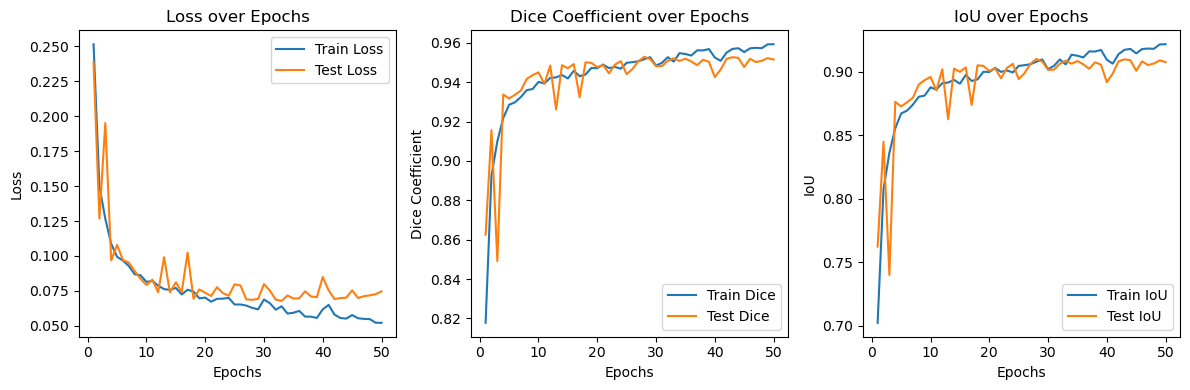

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 3, 2)
plt.plot(range(1, epochs+1), [d.cpu() for d in train_dices], label='Train Dice')
plt.plot(range(1, epochs+1), [d.cpu() for d in test_dices], label='Test Dice')
plt.title('Dice Coefficient over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()


plt.subplot(1, 3, 3)
plt.plot(range(1, epochs+1), [iou.cpu() for iou in train_ious], label='Train IoU')
plt.plot(range(1, epochs+1), [iou.cpu() for iou in test_ious], label='Test IoU')
plt.title('IoU over Epochs')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
model_save_path = "project3_TripleUNET.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to project3_TripleUNET.pth


In [11]:
model = TripleUNET(in_channels=3, out_channels=2)  
model.load_state_dict(torch.load("project3_TripleUNET.pth"))
model.to(device)
model.eval()


TripleUNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): TripleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): TripleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1,

In [14]:
mask_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor()
])
mask = Image.open("./Lung_segmentation/Test/Masks/810.png").convert('L')
mask_tensor = mask_transform(mask)


In [15]:
import matplotlib.pyplot as plt

model.eval()

transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image = Image.open("./Lung_segmentation/Test/Images/810.png")
input_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    prediction = model(input_tensor)

output = prediction.squeeze(0).cpu().numpy() 
output_channel = output[0]

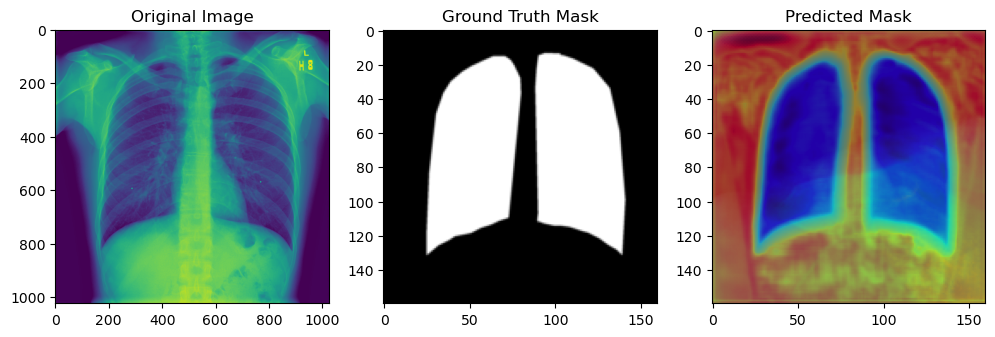

In [20]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(mask_tensor.squeeze(0), cmap='gray')
plt.title('Ground Truth Mask')

plt.subplot(1, 3, 3)
plt.imshow(image)
plt.imshow(output_channel, alpha=0.5, cmap='jet')  
plt.title('Predicted Mask')
plt.show()


# 4. Your IoU score should be higher than 0.85

## Test Loss: 0.0746, Test Dice: 0.9515, Test IoU: 0.9077

# 5. Write a 2-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.


## https://www.researchgate.net/publication/376076806_Lung_X-ray_Images_Segmentation_Task_Using_Limited_Datasets
## https://github.com/DengyiLiu/Deep_Learning_Project3

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file, and add paper link)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

     > = 0.85 -->10 points
     < 0.8  --> 0 points
     >= 0.8 & < 0.85  --> 2 point/0.01 higher
     

(6). Discussion - 10 points